In [ ]:
!pip install -r requirements.txt

In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy import data
import re
import random

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

SEED=42
torch.manual_seed(SEED)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Cleaning Data
Processing the text so embeddings can be created with it

In [3]:
df = pd.read_csv('dataset_2.csv')

df = df[['text', 'gender']]
df.dropna(axis=0,inplace=True)

df.gender.value_counts()

female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64

In [4]:
df.drop(df.loc[df['gender'] == 'unknown'].index, inplace=True)
df.drop(df.loc[df['gender'] == 'brand'].index, inplace=True)
df.gender = df['gender'].replace('male', 0)
df.gender = df['gender'].replace('female', 1)

In [5]:
def clean_text(text):
    descrip = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    return text

In [6]:
df.text = df.text.apply(lambda x: clean_text(x))
df.text.replace('[@+]', "", regex=True,inplace=True)
df.text.replace('[()]', "", regex=True,inplace=True)
df.text.replace('[#+]', "", regex=True, inplace=True)
df.text.replace('[�]', "", regex=True, inplace=True)
df.head()

,text,gender
0,robbie e responds to critics after win against...,0
1,it felt like they were my friends and i was li...,0
2,i absolutely adore when louis starts the songs...,0
3,hi jordanspieth - looking at the url - do you ...,0
4,watching neighbours on sky catching up with th...,1


In [7]:
df.to_csv('cleaned_data.csv', index=False)
df = pd.read_csv('cleaned_data.csv')

In [8]:
df.text = df.text.apply(lambda x: word_tokenize(x))

#Remove Stopwords
stop = stopwords.words('english')
df.text = df.text.apply(lambda x: [i for i in x if i not in stop])

df.head()

,text,gender
0,"[robbie, e, responds, critics, win, eddie, edw...",0
1,"[felt, like, friends, living, story, them۝, ht...",0
2,"[absolutely, adore, louis, starts, songs, hits...",0
3,"[hi, jordanspieth, -, looking, url, -, use, if...",0
4,"[watching, neighbours, sky, catching, neighbs,...",1


## Embeddings & Dataset

Using torchtext and w2v to create embeddings and the torch dataset that will be used for trainng 

In [9]:
#pre-trained embeddings
import gensim

w2v_model = gensim.models.Word2Vec(
            df.text, min_count=2)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)
w2v_model.train(df.text, total_examples= len(df.text), epochs=30)

Vocab size 8808


(3139397, 4541850)

In [10]:
w2v_model.save('embeddings.txt')
w2v_model = gensim.models.word2vec.Word2Vec.load('embeddings.txt')

In [11]:
def tokenizer(text):
  stop = stopwords.words('english')
  tokenized = word_tokenize(text)
  filtered = [w for w in tokenized if w.lower() not in stop]

  return filtered

In [12]:
#Create dataset and split to train, test 
TEXT = data.Field(tokenize=tokenizer, batch_first=True, include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

dataField = [("text",TEXT),("gender",LABEL)]

dataset = data.TabularDataset(path='cleaned_data.csv',format='csv',fields=dataField,skip_header=True)

train_data,val_data = dataset.split(split_ratio=0.8,random_state=random.seed(SEED))

In [23]:
#Glove as word embeddings

# TEXT.build_vocab(train_data)
# TEXT.vocab.load_vectors('glove.6B.100d')
# embedding = TEXT.vocab.vectors.to(device)

In [ ]:
#w2v as word embeddings
TEXT.build_vocab(train_data)
LABEL.build_vocab(train_data)

word2vec_vectors = []
for token, idx in (TEXT.vocab.stoi.items()):
    if token in w2v_model.wv.vocab.keys():
        word2vec_vectors.append(torch.FloatTensor(w2v_model[token]))
    else:
        word2vec_vectors.append(torch.zeros(100))

TEXT.vocab.set_vectors(TEXT.vocab.stoi, word2vec_vectors, 100)
embedding = torch.FloatTensor(TEXT.vocab.vectors)

In [14]:
batch = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  


train_iterator, val_iterator = data.BucketIterator.splits(
    (train_data, val_data), 
    batch_size = batch,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

## Model

Creating, training, evaluating the bidirectional LSTM classifier

In [15]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, embedding):
        super().__init__()
 
        # self.embedding = nn.Embedding(vocab_size, embedding_dim) #without pre-trained
        self.embedding = nn.Embedding.from_pretrained(embedding)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_len):
        #(batch, seq len, embed dim)
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_len.cpu(),batch_first=True)
        #(batch, n layer*2, hidden dim), (batch, n layer*2, hidden dim)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #final forward and backward state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        #(batch, hidden * 2)
        out = self.fc(hidden)
        out = self.act(out)
        return out

In [16]:
vocab_size = len(TEXT.vocab)
output_size = 1
embedding_dim = 100
hidden_dim = 32
n_layers = 2
bidirectional = True
dropout = 0.2

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_size, n_layers, dropout, embedding)
model = model.to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

def accuracy(true, pred):
    pred = torch.round(pred)
    correct = (pred == true).float() 
    acc = correct.sum() / len(correct)
    return acc

In [17]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()  
    for batch in iterator:
        optimizer.zero_grad()   
        text, text_len = batch.text   

        predictions = model(text, text_len).squeeze()  
        loss = criterion(predictions, batch.gender)        
        acc = accuracy(batch.gender, predictions)  

        loss.backward()       
        optimizer.step()      

        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_len = batch.text

            predictions = model(text, text_len).squeeze()
            loss = criterion(predictions, batch.gender)
            acc = accuracy(batch.gender, predictions)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Results

In [40]:
N_EPOCHS = 5
best_valid_loss = float('inf')
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion)

    train_loss_list.append(train_loss)
    val_loss_list.append(valid_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(valid_acc)
    
    print(f'Epoch: {epoch}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 0
	Train Loss: 0.677 | Train Acc: 56.50%
	 Val. Loss: 0.669 |  Val. Acc: 59.03%
Epoch: 1
	Train Loss: 0.663 | Train Acc: 59.55%
	 Val. Loss: 0.664 |  Val. Acc: 60.19%
Epoch: 2
	Train Loss: 0.657 | Train Acc: 60.75%
	 Val. Loss: 0.657 |  Val. Acc: 60.91%
Epoch: 3
	Train Loss: 0.648 | Train Acc: 61.88%
	 Val. Loss: 0.660 |  Val. Acc: 60.25%
Epoch: 4
	Train Loss: 0.640 | Train Acc: 63.44%
	 Val. Loss: 0.658 |  Val. Acc: 61.14%


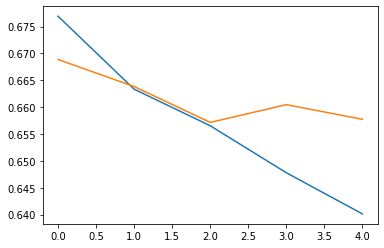

In [41]:
import matplotlib.pyplot as plt
epochs = range(5)
plt.plot(epochs, train_loss_list, label = 'Train Loss')
plt.plot(epochs, val_loss_list, label = 'Val Loss')
plt.show()

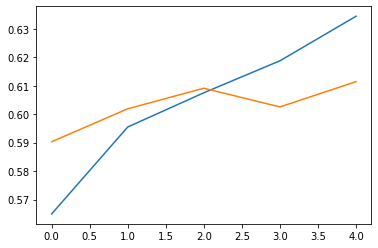

In [42]:
plt.plot(epochs, train_acc_list, label = 'Train Acc')
plt.plot(epochs, val_acc_list, label = 'Val Acc')
plt.show()